# Classification of Pulsar Stars From the HTRU2 Data Set

In [1]:
set.seed(1)
library(tidyverse) 
library(repr) 
library(tidymodels) 
library(ggplot2)
library(GGally)
library(cowplot)
library(caret)
library(yardstick)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1) Introduction

This dataset classifies radio signal profiles as those from pulsar stars or from non-pulsars/noise. Pulsars are a type of rare neutron star that are extremely dense and spin rapidly while emitting lots of light and radiation [] . The data for the stars comes from the HTRU2 (High Time Resolution Universe) Survey. The pulsars are detected through periodic radio signals that have slightly different emission patterns depending on rotation. However, sometimes detections of periodic radio signals are a result of RFI (radio frequency interference) and noise and not actual pulsars, which makes it more challenging to recognize a pulsar. For this dataset, we will use We have decided to use the following variables as predictors to conduct our classification: 

- mean of integrated profile
- excess kurtosis of integrated profile
- excess kurtosis of DM-SNR curve
- standard deviation of DM-SNR curve.

You will see how we chose our variables using a scatterplot and boxplot matrix in the methods section below. Integrated profile refers to the averaged emission of periodic radio signals over many rotations, since pulsar stars rotate. Kurtosis refers to the taildedness of a distrbtuon and whether it is light-tailed or heavy-tailed when compared to the normal distribution. Typically high kurtosis means more heavier tails and thus more outliers, whereas low kurtosis means the data hsa lighter tails and thus less outliers []. Mean refers to average and standard deviation refers to the varation in a data set.  

DM in DM-SNR refers to the Dispersion Measure, which essentially represents the number of free electorns between us and the pulsar per unit area []. SNR in DM-SNR refers to the Signal to Noise Ratio which "compares the level of a desired signal to the level of background noise" []. 

This dataset will use binary classification where "1" represents a pulsar, and "0" represents a non-pulsar/noise.

Our project then aims to answer the question: **Can we use the mean and excess kurtosis of the integrated profile and the excess kurtosis and standard deviations of the DM-SNR curves of signal profiles to predict whether a signal (of unknown class) is the result of a pulsar or non-pulsar?**

We will be building a classifier using the K-Nearest Neighbors (KNN) classification algorithm. Simply speaking, 
it is a machine learning method that is used for classification tasks by training the model on labeled data to make predictions on unseen data. The core of K-NN is that if two data points have similar features, they are likely to belong to the same class, in our case, pulsar (1) or non-pulsar (0). The value of K stands for the number of neighbors we are going to identify that has the closest 'distance' to the new data point that needs to be classified. The distance here is going to be Euclidean distance.  

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

## 2) Methods and Results

We will first read in the data from the web source, and display the data in a table with the variables displayed.  

In [2]:
# Read the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "data/pulsardata.zip") 
unzip("data/pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9)) 

colnames(pulsar_data) <- make.names(c("Mean of integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))


pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


Before we dive into building our classfier, we want to demonstrate how we determined which variables to use. We generated a scatterbox matrix accompaneid by box plots to the side and a distribution plot at the bottom. We looked for variables that had significant differences between the two classes. We determined that the mean of integrated profile, excess kurtosis of integrated profile, excess kurtosis of DM-SNR curve and the standard deviation of DM-SNR curve were good variables to use because these variable profiles exihibited signiciant differences between the two classes. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



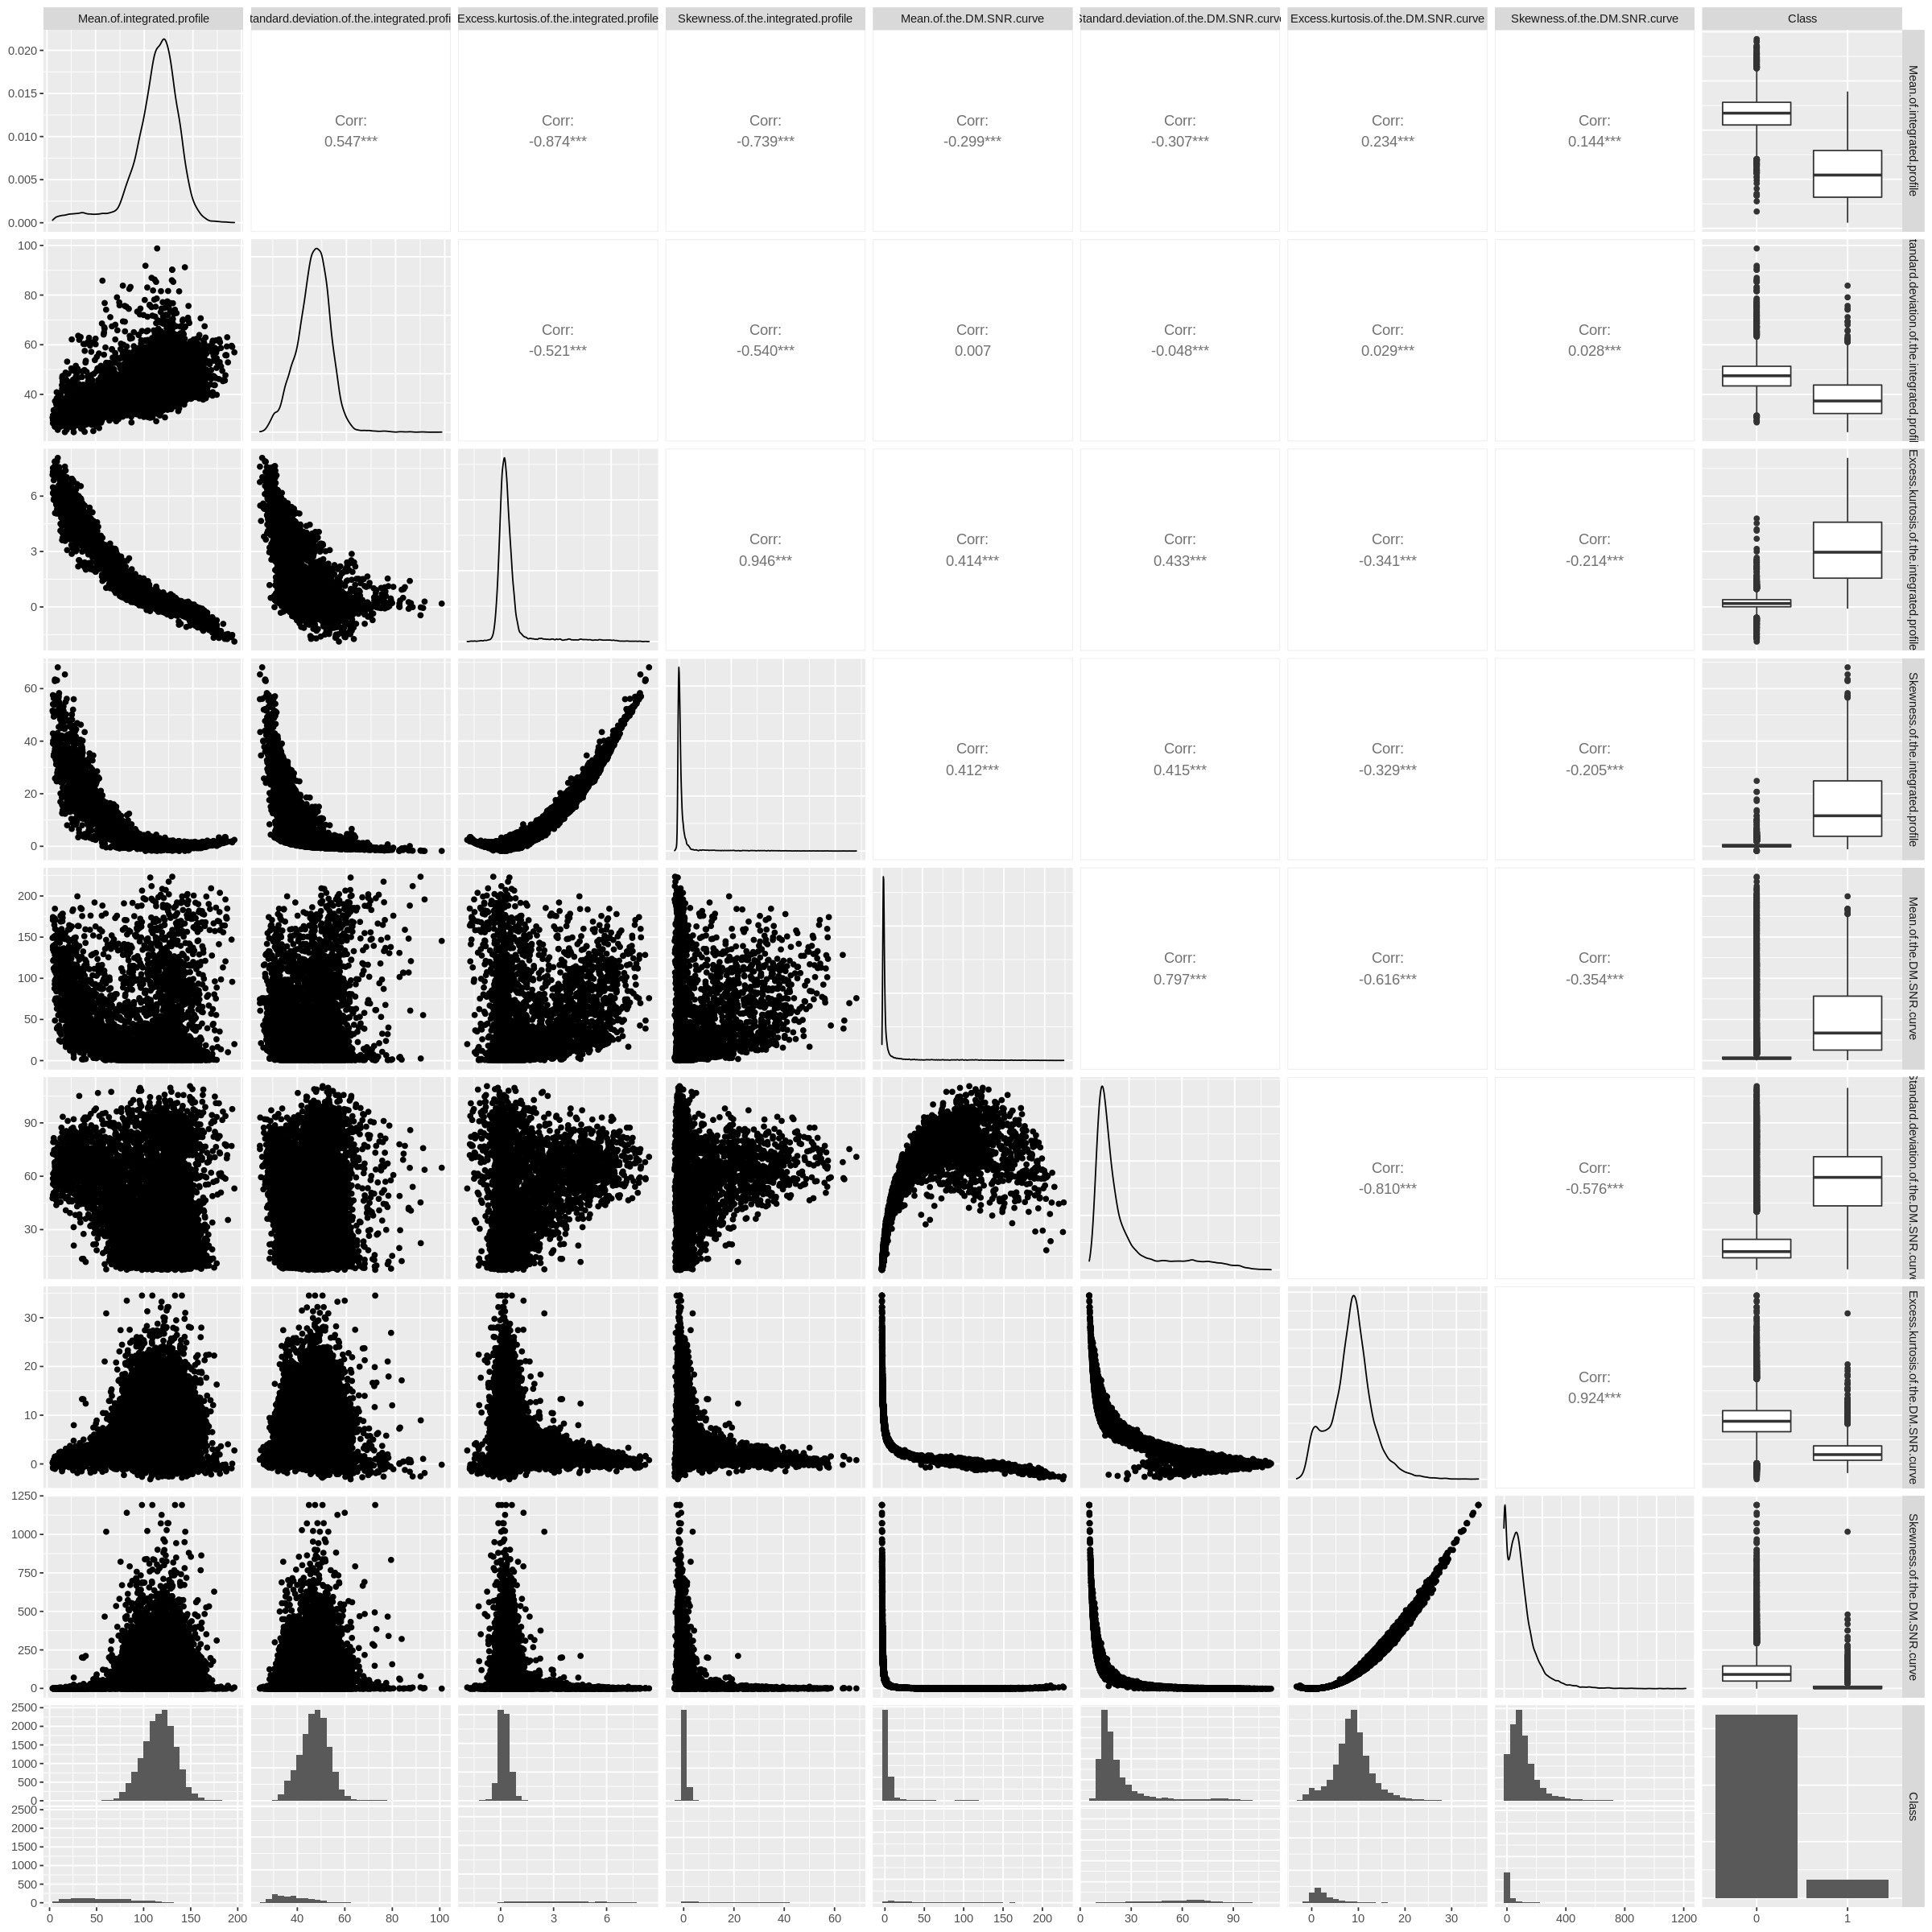

In [3]:
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(pulsar_data)

Now, we will begin cleaning wrangling to summarize our data. We will select for the variables we are interested for and also drop any rows that have missing values in the data frame.  

In [4]:
pulsar_data  <- pulsar_data |>
            select(Mean.of.integrated.profile, Excess.kurtosis.of.the.integrated.profile, Excess.kurtosis.of.the.DM.SNR.curve, Standard.deviation.of.the.DM.SNR.curve, Class) |>
            drop_na()

pulsar_data

Mean.of.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Excess.kurtosis.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,-0.234571412,7.975532,19.110426,0
102.50781,0.465318154,10.576487,14.860146,0
103.01562,0.323328365,7.735822,21.744669,0
136.75000,-0.068414638,6.896499,20.959280,0
88.72656,0.600866079,14.269573,11.468720,0
93.57031,0.531904850,10.621748,14.545074,0
119.48438,0.031460220,19.206230,9.279612,0
130.38281,-0.158322759,13.539456,14.378941,0
107.25000,0.452688025,9.001004,14.486853,0


Since we are building a classifier, we must split or data into training and testing data. The training data will be used to build our classifer and the testing data will be used once we have build the classifier in order to test it. We can also see how many observations are in our training data. Remember "0" means it is non-pulsar whereas "1" means it is a pulsar star. 

In [5]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

pulsar_summary <- pulsar_train  |>
    group_by(Class) |>
    summarise(count = n())

pulsar_summary


Class,count
<fct>,<int>
0,12200
1,1223


Let us compare the distribution of our variables in the training data through a scatterplot. 

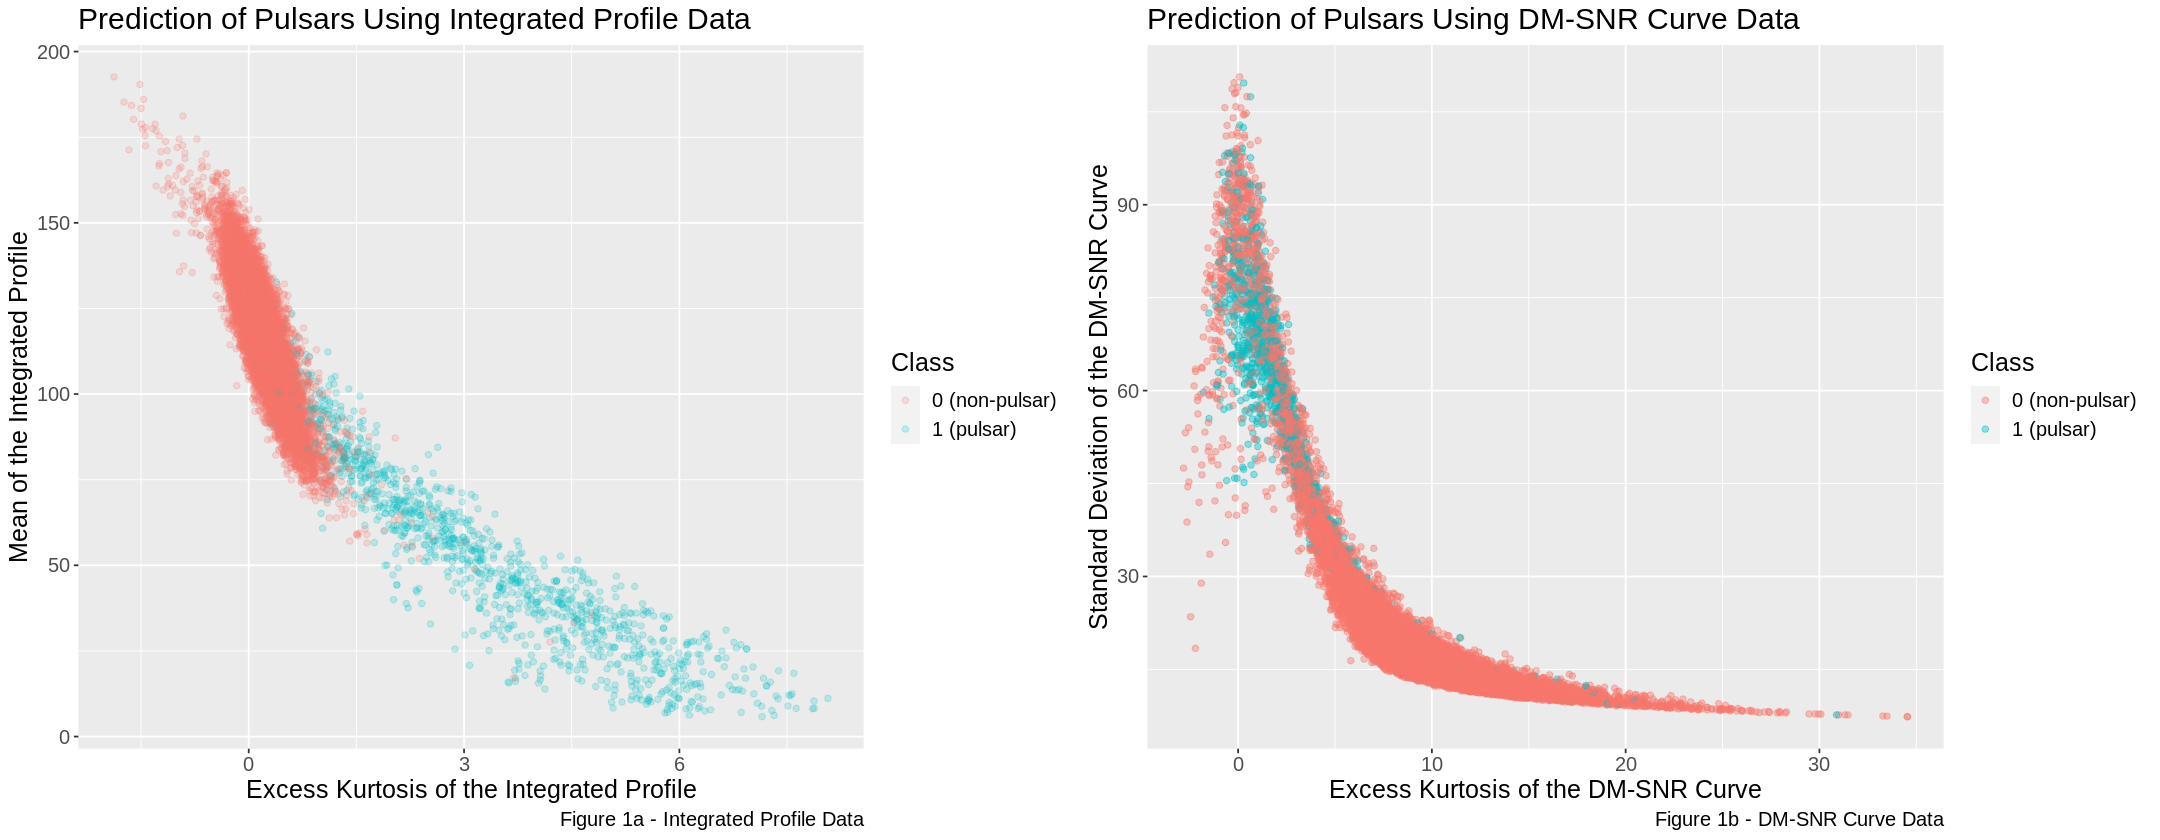

In [6]:
options(repr.plot.width = 18, repr.plot.height = 7)

mean_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.integrated.profile, y= Mean.of.integrated.profile, color = Class)) +
            geom_point(alpha = 0.2) +
            xlab("Excess Kurtosis of the Integrated Profile") + 
            ylab("Mean of the Integrated Profile") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using Integrated Profile Data") + 
            labs(caption = "Figure 1a - Integrated Profile Data") +
            theme(text = element_text(size = 15))

deviation_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.DM.SNR.curve, y= Standard.deviation.of.the.DM.SNR.curve, color = Class)) +
            geom_point(alpha = 0.4) +
            xlab("Excess Kurtosis of the DM-SNR Curve") + 
            ylab("Standard Deviation of the DM-SNR Curve") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using DM-SNR Curve Data") +
            labs(caption = "Figure 1b - DM-SNR Curve Data") +
            theme(text = element_text(size = 15))


plot_grid(mean_pulsar_plot, deviation_pulsar_plot, nrow = 1)    

Since KNN is sentive to the scale of predictors, we should also do some preprocessing to standarize the data. We are going to create a recipe that first selects the variables we want to use as predictors, then scale and center to standarize the data.

In [7]:
pulsar_recipe <- recipe(Class ~.,data = pulsar_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
#pulsar_recipe

Next, we will actually create and specify the K-NN model to help us figure out which parameters we will want to use, such as the value of K and distance metric. However, it could be really hard to find the optimal value of K that comes up with the most precise classifications, so we have to tune our models to find the best K. 

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")
#knn_spec

Then, to experiment with some possible Ks and pick up the best of it, we make use of a method called 5-gold cross-validation. The idea of 5-fold cross-validation is we split the overall training data into 5 evenly-sized chunks, and then iteratively use 1 chunk as validation set and the remaining chunks as training set. We train our model on the training set and test on the validation set. Then we can get a sence of how our model works without touching the actual test set. When constructing a cross-validation, we should also specify how many folds we would like to divide the training set into, and here we are using five folds.

In [9]:
pulsar_vfold <- vfold_cv(pulsar_data, v = 5, strata = Class)

Finally, we create a workflow that combines the model specification, recipe and cross-validation together. We then execute the workflow and collect the performance metric of each model with a specific parameter. Remember we are tunning the model with different K, so we also have to specify how many K's we would like to experiment with, and here we are using 20 K values in our tuning. 

In [10]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

pulsar_result <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
    collect_metrics()

pulsar_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9674825,5,0.0011397137,Preprocessor1_Model01
1,roc_auc,binary,0.9026980,5,0.0043978458,Preprocessor1_Model01
2,accuracy,binary,0.9674825,5,0.0011397137,Preprocessor1_Model02
2,roc_auc,binary,0.9297721,5,0.0034036246,Preprocessor1_Model02
3,accuracy,binary,0.9775953,5,0.0003346404,Preprocessor1_Model03
3,roc_auc,binary,0.9385220,5,0.0028310075,Preprocessor1_Model03
4,accuracy,binary,0.9775953,5,0.0003346404,Preprocessor1_Model04
4,roc_auc,binary,0.9417820,5,0.0027902804,Preprocessor1_Model04
5,accuracy,binary,0.9788804,5,0.0003587422,Preprocessor1_Model05


Now let's decide which K value is the best by plotting the K values and its accuracies displayed in a line graph.

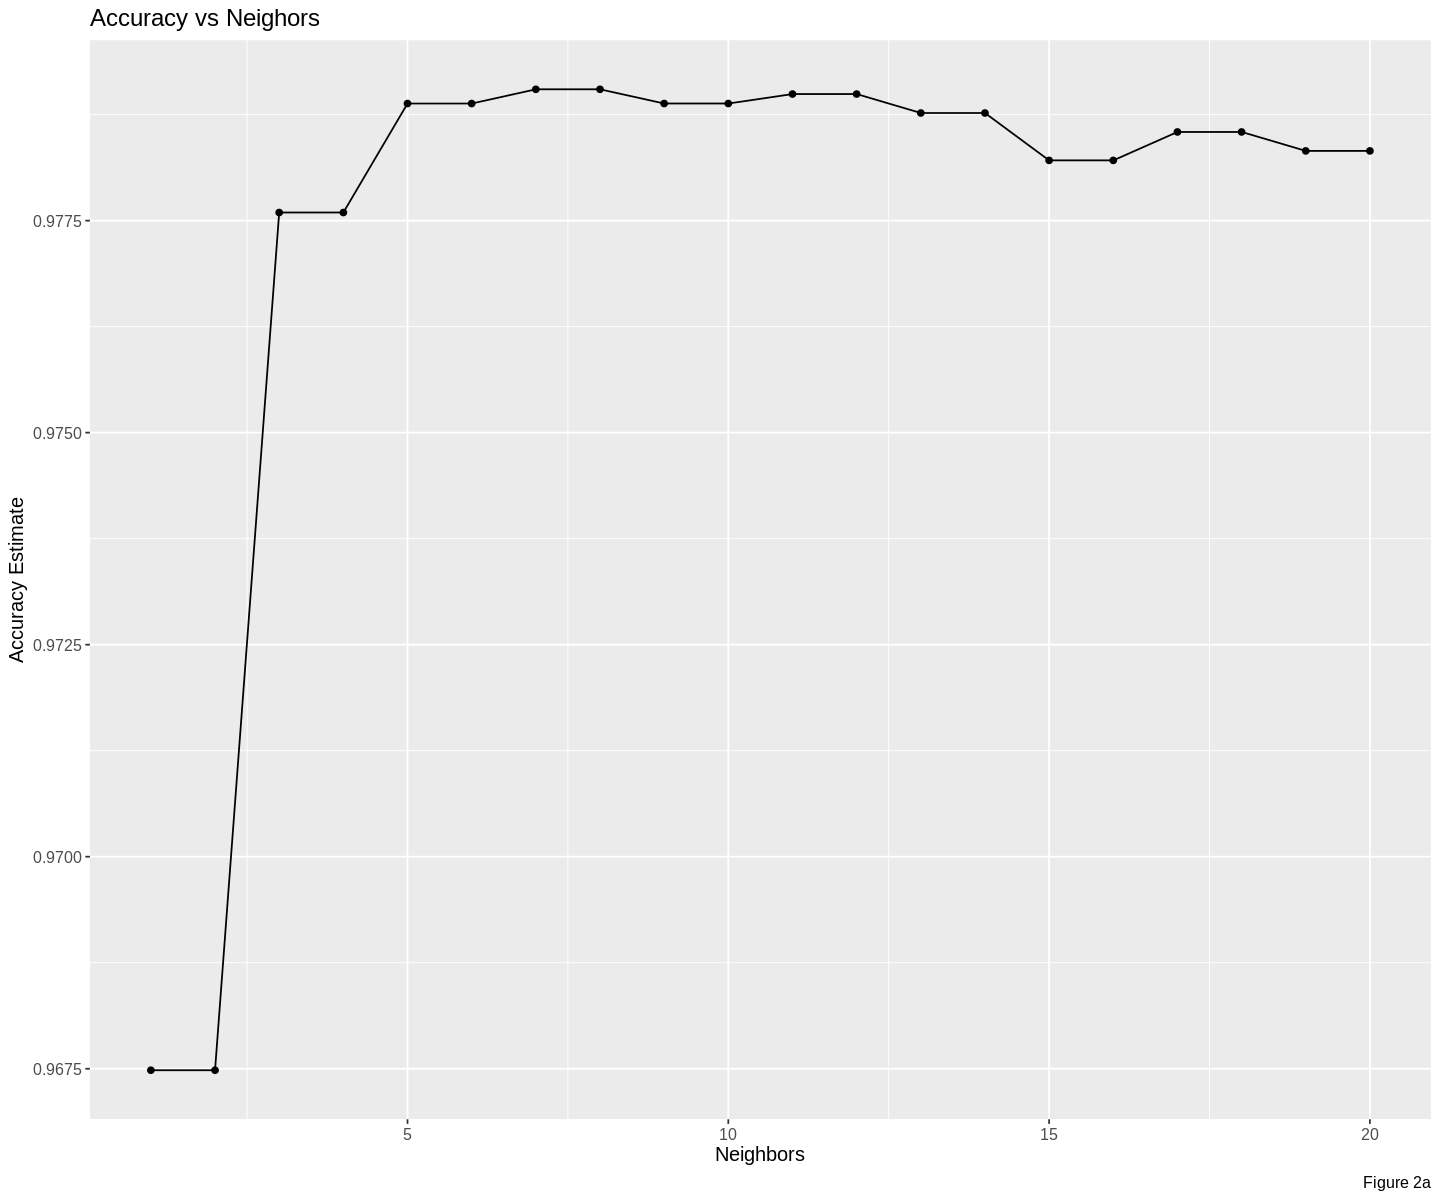

In [11]:
options(repr.plot.width = 12, repr.plot.height = 10)

accuracies <- pulsar_result |> 
       filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighors", caption = "Figure 2a") + 
  theme(text = element_text(size = 12)) 

accuracy_vs_k

In the graph, we can clearly see that the accuracy is highest when K = 7 or 8, but we will choose k = 7 since it is better to have an odd k to avoid ties. 

Now let us use K = 7 to create the KNN modeland put evrything into a workflow. 

In [12]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
              set_engine("kknn") |>
              set_mode("classification")

best_fit <- workflow() |>
             add_recipe(pulsar_recipe) |>
             add_model(best_spec) |>
             fit(data = pulsar_train)

best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02056172
Best kernel: rectangular
Best k: 7

Now, let us use the final model we have on the test dataset. We will also report the accuracy of the testing and the confusion matrix. 

In [13]:
pulsar_predictions <- predict(best_fit, pulsar_test) |>
                        bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |> 
                  metrics(truth = Class, estimate = .pred_class)

pulsar_conf_mat <- pulsar_predictions |>
                        conf_mat(truth = Class, estimate = .pred_class) 
pulsar_metrics
pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9792179
kap,binary,0.8719297


          Truth
Prediction    0    1
         0 4030   64
         1   29  352

We have also create a visualization of our confusion matrix below. 

Warning message:
“attributes are not identical across measure variables; they will be dropped”
ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'Prediction' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = erro

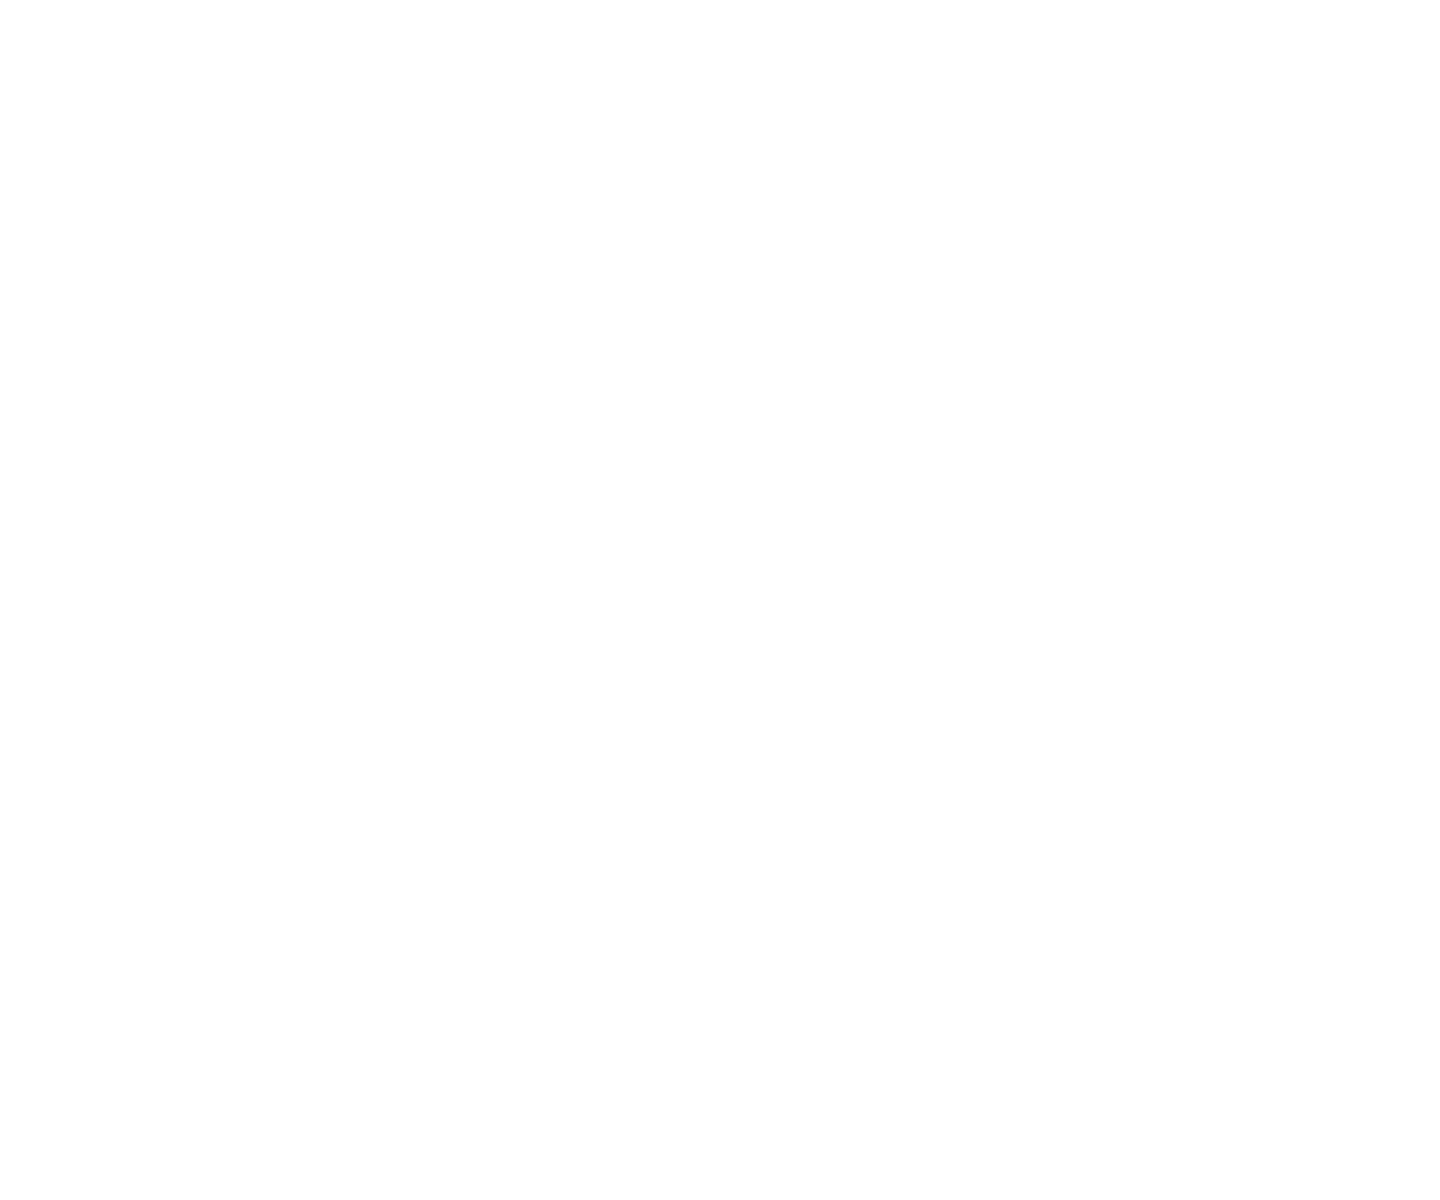

In [15]:
pulsar_conf_df <- as.data.frame(pulsar_conf_mat$table)
pulsar_conf_df$Truth <- rownames(pulsar_conf_df)

pulsar_conf_long <- reshape2::melt(pulsar_conf_df, id.vars = "Truth")

hello <- ggplot(data = pulsar_conf_long, aes(x = Prediction, y = Truth, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), color = "white") +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Pulsar Confusion Matrix", x = "Predicted", y = "True")

hello

## 3) Discussion

When we look at the metrics computed above, we can see that we have an accuracy of 0.98 or 98%, which means that our classifier did a good job for the most part at whether something was pulsar(1) or non-pulsar (0). Through the confusion matrix, we can also see that majority of the predictions are 0 (non-pulsars). This is what we expected to find, as pulsar stars are a type of neutron star and neutron stars are quite rare in general []. 

Pulsar stars can be valuable tools to help predict other space and physics phenomena since it is known widely that they are very dense and emit a lot of radiation. By building a classifer that helps identify pular stars faster, it may help to speed up scientific research and discovery within astronomy. For example, pulsar stars can carry information about other things like space-time and gravitational waves caused by motions of things like blackholes[]. By understanding pulsars, we may be able to answer to what extent can pulsars be predictve and provide information of other space and astrophysics phenomena. 

Furthermore, by looking at what is classified as non-pulsar/noise, these findings may help uncover the discovery of new stars and their characteristics. In addition, by finding where pulsar stars are located, this can help us find where pulsar planets are located and the frequency of these planets. Pulsar planets are rare and form when a big star (much bigger than the sun), exploes [].  One future question may raise up is to what extent the pulsars we identify using our model would help us verify our current theories of physics and the universe, as pulsars are already being used to look at Einstein's Theory of Relativity [].  

## 4) References (IEEE Format)